Struttura del notebook

3. Suddivisione e Scaling
    - Separazione dei dati in set di addestramento e test.
    - Standardizzazione dei dati numerici.
    - Controllo della suddivisione e scaling.

4. Addestramento e Valutazione del Modello
    - Selezione e addestramento del modello (e.g., Random Forest, Regressione Logistica).
    - Valutazione delle performance del modello (accuratezza, precisione, recall).
    - Tuning degli iperparametri.

5. Conclusioni e Passi Successivi
    - Riepilogo dei risultati e performance.
    - Conclusioni.


## Import Libraries

In [1]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import pickle

# Split Data & Scaling

In [2]:
df = pd.read_csv('./dataset/preprocessed_data.csv')

#df = pd.read_csv('preprocessed_data.csv')
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

Si scala le caratteristiche in modo che siano normalizzate con media zero. Questo passaggio è consigliato per le SVM e modelli lineari, poiché facilita l'adattamento del modello. Considerata la presenza di outlier, si è optato per utilizzare uno StandardScaler anziché un MinMaxScaler

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

## Correlation

In [7]:
correlation_matrix = df.corr()
correlation_matrix

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,annual_inc,verification_status,loan_status,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
loan_amnt,1.000000,0.999262,0.997113,0.411616,0.144827,0.944981,-0.156386,0.332816,0.278240,-0.069405,...,-0.012802,0.000350,-0.052674,-0.067035,-0.063753,-0.130026,-0.014508,0.008637,-0.073511,-0.026164
funded_amnt,0.999262,1.000000,0.998023,0.410659,0.144964,0.946010,-0.156064,0.332585,0.278110,-0.070726,...,-0.012996,0.000140,-0.052901,-0.067086,-0.063814,-0.130245,-0.014590,0.007490,-0.073502,-0.026494
funded_amnt_inv,0.997113,0.998023,1.000000,0.411299,0.145010,0.943635,-0.154030,0.331538,0.280169,-0.073805,...,-0.013239,-0.000344,-0.053099,-0.067065,-0.063775,-0.130850,-0.014882,0.003948,-0.073263,-0.027988
term,0.411616,0.410659,0.411299,1.000000,0.427969,0.144892,-0.451765,0.058422,0.193879,-0.098852,...,0.004718,-0.000754,-0.016701,-0.024713,-0.027563,-0.046712,-0.006811,-0.006581,-0.034209,-0.014700
int_rate,0.144827,0.144964,0.145010,0.427969,1.000000,0.132906,-0.977308,-0.072691,0.218546,0.029159,...,-0.012481,0.040851,-0.018403,0.029629,0.044379,0.091328,0.012479,0.074185,0.018312,0.010651
installment,0.944981,0.946010,0.943635,0.144892,0.132906,1.000000,-0.134582,0.326298,0.261307,-0.035437,...,-0.016745,0.005781,-0.053462,-0.063159,-0.058253,-0.117846,-0.012424,0.022185,-0.069931,-0.022316
sub_grade,-0.156386,-0.156064,-0.154030,-0.451765,-0.977308,-0.134582,1.000000,0.065863,-0.221636,0.014764,...,0.009719,-0.041019,0.016858,-0.031092,-0.046095,-0.094321,-0.012986,-0.077947,-0.018775,-0.006704
annual_inc,0.332816,0.332585,0.331538,0.058422,-0.072691,0.326298,0.065863,1.000000,0.083743,-0.005200,...,0.058691,0.005418,0.003632,-0.004378,-0.008326,-0.018295,0.000019,0.024969,-0.009230,-0.004443
verification_status,0.278240,0.278110,0.280169,0.193879,0.218546,0.261307,-0.221636,0.083743,1.000000,-0.048001,...,-0.007105,0.006994,-0.024774,-0.013954,-0.010438,-0.011800,0.000954,0.026991,-0.010205,-0.012224
loan_status,-0.069405,-0.070726,-0.073805,-0.098852,0.029159,-0.035437,0.014764,-0.005200,-0.048001,1.000000,...,0.005849,0.018948,0.022647,0.006858,0.010874,0.016021,0.006920,0.020602,0.007277,0.044825


Alta correlazione tra molte delle caratteristiche è un'indicazione che l'uso di PCA (Analisi delle Componenti Principali) potrebbe essere vantaggioso.

# Feature Reduction

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=len(X_train.columns))
pca.fit(X_train)

PCA(n_components=52)

In [10]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

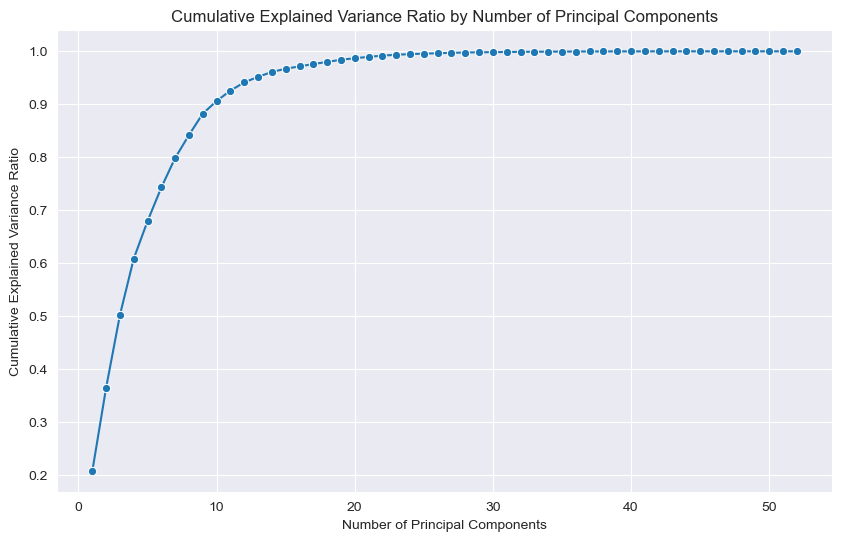

In [11]:
# Create a DataFrame for cumulative explained variance ratio
cvr = pd.DataFrame({
    'Number of Principal Components': range(1, len(cumulative_variance) + 1),
    'Cumulative Explained Variance Ratio': cumulative_variance
})

# Set up the figure
plt.figure(figsize=(10, 6))

# Create the line plot using Seaborn
sns.lineplot(data=cvr, 
             x='Number of Principal Components', 
             y='Cumulative Explained Variance Ratio', 
             marker='o')  # Adding markers for clarity

# Add title and labels
plt.title('Cumulative Explained Variance Ratio by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')

# Add grid lines for better readability
plt.grid(True)

# Show the figure
plt.show()

In [12]:
components_to_retain = np.argmax(cumulative_variance >= 0.9) + 1
pca = PCA(n_components=components_to_retain)

X_train_pca = pca.fit_transform(X_train)

X_test_pca = pca.transform(X_test)
components_to_retain

13

## Modeling

### Funzioni di utilità

In [13]:
def save_model(model, filename):
    filename = './models'+'/'+filename
    try:
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
        print(f"Modello salvato con successo in: {filename}")
    except Exception as e:
        print(f"Errore nel salvataggio del modello: {e}")

In [14]:
def save_grid_search_results(results, columns_to_save, filename):
    filename = './results'+'/'+filename

    # Seleziona le colonne principali per il CSV
    results_to_save = results[columns_to_save]

    # Identifica il miglior modello basato su mean_test_score
    best_index = results['mean_test_score'].idxmax()  # Indice del miglior punteggio medio

    # Aggiungi una colonna che indica se il modello è il migliore
    results_to_save['is_best_model'] = False
    results_to_save.loc[best_index, 'is_best_model'] = True

    # Salva i risultati in un file CSV
    results_to_save.to_csv(filename, index=False)
    print(f"Risultati salvati con successo in: {filename}")

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true, y_pred)

    # Configura la visualizzazione
    plt.figure(figsize=(8,6))
    class_labels = sorted(set(y_true) | set(y_pred))  # Unisce le classi uniche di y_true e y_pred
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)

    # Aggiungi titolo e etichette
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)

    # Mostra il grafico
    plt.show()

In [16]:
def plot_roc_curve(y_true, y_pred_proba):
    # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        for i in range(11):
            fpr[i], tpr[i], _ = roc_curve(y_true, y_pred_proba[:, i], pos_label=i)
            roc_auc[i] = roc_auc_score(y_true == i, y_pred_proba[:, i]) # AUC for each class

        # Plot all ROC curves
        plt.figure(figsize=(8, 6))
        for i in range(11):
            plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

        plt.plot([0, 1], [0, 1], 'k--')  # Random diagonal
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-class')
        plt.legend(loc="lower right")
        plt.show()

In [17]:
def plot_learning_curve(clf, X_train, y_train, cv=5):
    # Calcolo delle curve di apprendimento
    train_sizes, train_scores, valid_scores = learning_curve(clf, X_train, y_train, train_sizes=np.linspace(0.1, 1.0, 10), cv=cv)

    # Calcolo delle medie e delle deviazioni standard per i punteggi
    mean_train_scores = np.mean(train_scores, axis=1)
    mean_valid_scores = np.mean(valid_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    std_valid_scores = np.std(valid_scores, axis=1)

    # Configura la figura
    fig, ax = plt.subplots(figsize=(8, 6))

    # Traccia i punteggi di allenamento e validazione
    ax.plot(train_sizes, mean_train_scores, 'o-', color='b', label='Training accuracy')
    ax.plot(train_sizes, mean_valid_scores, 'x-', color='r', label='Validation accuracy')

    # Aggiungi aree ombreggiate per le deviazioni standard
    ax.fill_between(train_sizes, mean_train_scores - std_train_scores, mean_train_scores + std_train_scores, color='b', alpha=0.2)
    ax.fill_between(train_sizes, mean_valid_scores - std_valid_scores, mean_valid_scores + std_valid_scores, color='r', alpha=0.2)

    # Etichette e titolo
    ax.set_xlabel("Training examples", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Learning Curve", fontsize=14)
    ax.legend(loc="best")

    # Mostra il grafico
    plt.grid(True)
    plt.show()


In [18]:
def plot_feature_importance(model, X_train):
    # Crea un DataFrame con le importanze delle feature
    feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Gini Importance': model.feature_importances_})
    feature_imp_df = feature_imp_df.sort_values('Gini Importance', ascending=False)

    # Visualizzazione della tabella delle importanze delle feature
    print(feature_imp_df)

    # Crea un grafico a barre orizzontali per l'importanza delle feature
    plt.figure(figsize=(8,6))
    plt.barh(feature_imp_df['Feature'], feature_imp_df['Gini Importance'], color='skyblue')
    plt.xlabel('Gini Importance')
    plt.title('Feature Importance - Gini Importance')
    plt.gca().invert_yaxis()  # Inverte l'asse y per visualizzare la feature più importante in alto
    plt.show()


### SVM

In [ ]:
#Creo il classificatore SVM
svm = SVC()

# Definisco la griglia di iperparametri
param_grid = {
    'C': [1, 10],                # Ridotto ai valori più comuni per C
    'kernel': ['linear', 'rbf'], # Mantenuto solo il kernel lineare per semplificare
}

# Utilizzo il Grid Search
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

#  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_svm_model = grid_search.best_estimator_

# Predico sul set di test
y_pred = best_svm_model.predict(X_test)

# Learning curves
plot_learning_curve(best_svm_model, X_train, y_train)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

#Salvataggio dei risultati
columns_to_save = [
        'param_C', 'param_kernel', # Parametri del modello
        'mean_test_score', 'std_test_score',                      # Media e deviazione standard dei punteggi
        'rank_test_score'                                         # Rank del modello
    ]
save_grid_search_results(pd.DataFrame(grid_search.cv_results_), columns_to_save, 'svm_results.csv')

# Salvataggio del miglior modello SVM
save_model(best_svm_model, "best_svm_model.pkl")

Fitting 5 folds for each of 4 candidates, totalling 20 fits


### Logistic Regression

In [ ]:
# Creo il modello Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=100)

# Definisco la griglia di iperparametri
param_grid = {
    'penalty': ['l2', 'none'],        # Limitato ai tipi di penalizzazione più comuni
    'C': [0.1, 1, 10],                # Ridotto l'intervallo di valori per C
    'solver': ['lbfgs', 'liblinear'], # Meno solver per velocizzare la ricerca
}

# Grid Search
grid_search = GridSearchCV(
    estimator=lr,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_lr_model = grid_search.best_estimator_

# Predizioni sul set di test
y_pred = best_lr_model.predict(X_test)

# Learning curves
plot_learning_curve(best_lr_model, X_train, y_train)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

#Salvataggio dei risultati
columns_to_save = [
    'param_penalty', 'param_C', 'param_solver',                   # Parametri del modello
    'mean_test_score', 'std_test_score',                          # Media e deviazione standard dei punteggi
    'rank_test_score'                                             # Rank del modello
]
save_grid_search_results(pd.DataFrame(grid_search.cv_results_), columns_to_save, 'lr_results.csv')

# Salvataggio del miglior modello Logistic Regression
save_model(best_lr_model, "best_lr_model.pkl")

### Random Forest


In [ ]:
# Creazione il modello Random Forest
rf = RandomForestClassifier(random_state=42)

# Definisco la griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],          # Numero di alberi (limitato a 100 e 200)
    'max_depth': [10, 20],                # Profondità massima (limitato a 10 e 20)
    'min_samples_leaf': [1, 2],           # Minimo numero di campioni per una foglia (limitato a 1 e 2)
}

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Individuo il  Miglior modello trovato
print("Migliori parametri trovati: ", grid_search.best_params_)
best_rf_model = grid_search.best_estimator_

# Predico sul set di test
y_pred = best_rf_model.predict(X_test)

# Learning curves
plot_learning_curve(best_rf_model, X_train, y_train)

#  Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

#  Matrice di confusione
plot_confusion_matrix(y_test, y_pred)

# Feature importance
plot_feature_importance(best_rf_model, X_train)

#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_max_features',  # Parametri del modello
    'mean_test_score', 'std_test_score',                                                                               # Media e deviazione standard dei punteggi
    'rank_test_score'                                                                                                  # Rank del modello
]
save_grid_search_results(pd.DataFrame(grid_search.cv_results_), columns_to_save, 'rf_results.csv')

# Salvataggio del miglior modello RF
save_model(best_rf_model, "best_rf_model.pkl")

### XGBoost

In [ ]:
# Creo del modello XGBoost
model = XGBClassifier(
    objective='multi:softmax',  # Per classificazione multiclasse
    random_state=42,
    use_label_encoder=False,    # Rimosso per evitare warning
    eval_metric='mlogloss'      # Specifica la metrica di valutazione
)

# Definizione della griglia di iperparametri
param_grid = {
    'n_estimators': [100, 200],           # Numero di boosting rounds (limitato a 100 e 200)
    'learning_rate': [0.01, 0.1],         # Step size (limitato a 0.01 e 0.1)
    'max_depth': [3, 5],                   # Profondità massima dell'albero (limitato a 3 e 5)
    'subsample': [0.8, 1.0],               # Sottocampione dei dati (limitato a 0.8 e 1.0)
}

#  Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='f1_weighted',  # Ottimizzare per F1-score ponderato
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

# Miglior modello
print("Migliori parametri trovati: ", grid_search.best_params_)
best_xgb_model = grid_search.best_estimator_

#  Predizioni sul set di test
y_pred = best_xgb_model.predict(X_test)

# Learning curves
plot_learning_curve(best_xgb_model, X_train, y_train)

# Report di classificazione
print("Classification report on test set:")
print(classification_report(y_test, y_pred))

#plot confusion matrix
plot_confusion_matrix(y_test, y_pred)

#Salvataggio dei risultati
columns_to_save = [
    'param_n_estimators', 'param_learning_rate', 'param_max_depth',
    'param_subsample', 'param_colsample_bytree', 'param_gamma', 'param_reg_lambda',
    'mean_test_score', 'std_test_score', 'rank_test_score'
]
save_grid_search_results(pd.DataFrame(grid_search.cv_results_), columns_to_save, 'xgb_results.csv')

# Salvataggio del miglior modello XGBoost
save_model(best_xgb_model, "best_xgb_model.pkl")

## SHAP

In [ ]:
# SHAP Explainer
explainer = shap.Explainer(best_rf_model, X_test)
shap_values = explainer(X_test)

# Initialize the SHAP JavaScript library
shap.initjs()
# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])
# If SHAP values are an Explanation object, extract the values
if isinstance(shap_values, shap.Explanation):
    shap_values = shap_values.values

In [ ]:
# Force plot for the first observation with matplotlib
# The expected_value is the model's expected output for the dataset
# The shap_values[0] represents the SHAP values for the first observation
# X_test.iloc[0, :] is the corresponding feature values for the first observation
shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :], matplotlib=True)

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.plots.beeswarm(shap_values)